# Loading and viewing data

In [1]:
# The code was removed by Watson Studio for sharing.

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [2]:
body = client_d861f9d8f5e84b96a0da1d2baec38f0a.get_object(Bucket='onlinebookrecommendersystem-donotdelete-pr-xhkfop0pxalwme',Key='BX-Books.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

books = pd.read_csv(body, sep=';', error_bad_lines=False, encoding='latin-1')
books.head()


b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interact

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [3]:
body = client_d861f9d8f5e84b96a0da1d2baec38f0a.get_object(Bucket='onlinebookrecommendersystem-donotdelete-pr-xhkfop0pxalwme',Key='BX-Users.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

users = pd.read_csv(body, sep=';', error_bad_lines=False, encoding='latin-1')
users.head()


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


# Data Preprocessing

In [4]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [5]:
print(ratings.shape)
print(list(ratings.columns))

(1149780, 3)
['User-ID', 'ISBN', 'Book-Rating']


#### Understanding rating distribution

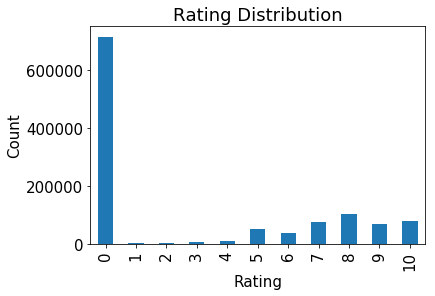

In [6]:
plt.rc('font', size=15)
ratings['Book-Rating'].value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [7]:
print(books.shape)
print(list(books.columns))
print(users.shape)
print(list(users.columns))

(271360, 8)
['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
(278858, 3)
['User-ID', 'Location', 'Age']


#### Understanding rating distribution

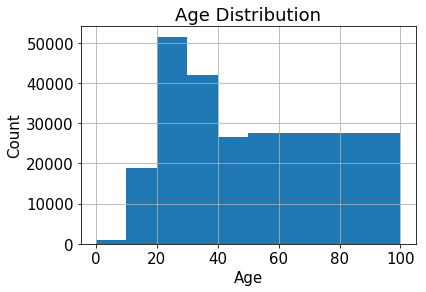

In [8]:
users['Age'].hist(bins=[0,10,20,30,40,50,100])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

To ensure statistical significance, we'll filter out the following observations:
1. users who have rated less than 200 books
2. books that have been rated by less than 100 users

This is considering that the above oservations won't be credible enough

In [9]:
counts1 = ratings['User-ID'].value_counts()
ratings = ratings[ratings['User-ID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['Book-Rating'].value_counts()
ratings = ratings[ratings['Book-Rating'].isin(counts[counts >= 100].index)]

# Model Building: Collaborative Filtering Using K-Nearest Neighbors

We plan to use KNN algorithm to build our collaborative filtering model. 
KNN is a machine learning algorithm. It clusters similar users based on similar rating patterns and make predictions based on that. 
For example, we first present ratings in a matrix with the matrix having one row for user and one column for books.
So, first of all we'll combine ratings dataframe and books dataframe based on 'ISBN' column (which exists in both data frames) and remove the columns which are not required for building a collaborative filtering model. 

In [10]:
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns=['Year-Of-Publication', 'Publisher', 'Book-Author','Image-URL-S', 'Image-URL-M', 'Image-URL-L']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...


We then group by book titles and create a new column for total rating count. Thereby each row have unique book titles with their number of ratings in the adjacent column.

In [11]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['Book-Title'])

book_ratingCount = (combine_book_rating.
     groupby(by = ['Book-Title'])['Book-Rating'].
     count().
     reset_index().
     rename(columns = {'Book-Rating': 'totalRatingCount'})
     [['Book-Title', 'totalRatingCount']]
    )
book_ratingCount.head()

,Book-Title,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


Now that we have the book titles and their rating count,we combine the book rating data with the total rating count data using left join (which means, that columns of book rating data will be in the left). This will help us know the popular books and also help us filter out the 'not-so-popular' books.


In [12]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
rating_with_totalRatingCount.head()

,User-ID,ISBN,Book-Rating,Book-Title,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


Understanding the rating count distribution

In [13]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   160576.000
mean         3.044
std          7.428
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        365.000
Name: totalRatingCount, dtype: float64


The median book has been rated once. 
Let's look at the books that are rated more number of times

In [14]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    5.000
0.910    6.000
0.920    7.000
0.930    7.000
0.940    8.000
0.950   10.000
0.960   11.000
0.970   14.000
0.980   19.000
0.990   31.000
Name: totalRatingCount, dtype: float64


We think that books that are rated more than 31 times are popuar. So, that will be our popularity threshold

In [15]:
popularity_threshold = 31
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,User-ID,ISBN,Book-Rating,Book-Title,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [16]:
rating_popular_book.shape

(96831, 5)

In [17]:
combined = rating_popular_book.merge(users, left_on = 'User-ID', right_on = 'User-ID', how = 'left')
user_rating=combined.drop('Age', axis=1)
user_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,totalRatingCount,Location
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"gilbert, arizona, usa"
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"knoxville, tennessee, usa"
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82,"n/a, n/a, n/a"
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"byron, minnesota, usa"
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"cordova, tennessee, usa"


The data is ready to be converted into a matrix now. We will use cosine similarity for clustering similar movies. 

In cosine similarity each and every movie represented into vectors, these vectors will be populated into graphs.

We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors). We then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations. This matrix is then converted into a pivot table so that it can be converted into an array for the calculations.

Finding the Nearest Neighbors We use unsupervised algorithms with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is “brute”, and we specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors. Finally, we fit the model.

In [18]:
from scipy.sparse import csr_matrix
user_rating = user_rating.drop_duplicates(['User-ID', 'Book-Title'])
user_rating_pivot = user_rating.pivot(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
user_rating_matrix = csr_matrix(user_rating_pivot.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(user_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

The above is the model we have used.

In [1]:
query_index = np.random.choice(user_rating_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 10)

NameError: name 'np' is not defined

The above code randomly chooses an index of a book and calculates the the distances and indices of 5 closest books.

Now, let's see how the matrix of the book looks like.

In [46]:
user_rating_pivot.iloc[query_index,:].values.reshape(1,-1)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

# Results

Let's see the name of the movie that is randomly chosen.

In [47]:
user_rating_pivot.index[query_index]

'After the Fire'

Based on the above book, we see 5 recommended books (along with their indices and distances - how similar is this particular book to the book that was liked).

In [48]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for After the Fire:

1: Wild Justice, with distance of 0.40482186977570034:
2: Fatal Cure, with distance of 0.46870788944033626:
3: Smart Women, with distance of 0.5332019329005259:
4: Blue Moon, with distance of 0.5421970730452377:
5: Blindsight, with distance of 0.5862265490464966:
6: The Sky Is Falling, with distance of 0.6032839124339906:
7: Promises, with distance of 0.6082586056155472:
8: Contagion, with distance of 0.6099884413925267:
9: The Outside Man, with distance of 0.6106767854780957:


In [40]:
user_rating_pivot2 = user_rating.pivot(index = 'User-ID', columns = 'Book-Title', values = 'Book-Rating').fillna(0)
user_rating_pivot2.head()

Book-Title,10 Lb. Penalty,16 Lighthouse Road,1984,1st to Die: A Novel,2010: Odyssey Two,204 Rosewood Lane,24 Hours,2nd Chance,3rd Degree,4 Blondes,...,"Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players",World of Pies : A Novel,Writ of Execution,Wuthering Heights,Wuthering Heights (Penguin Classics),Year of Wonders,You Belong To Me,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw"""
User-ID,,,,,,,,,,,,,,,,,,,,,
254,0.000,0.000,9.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2276,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2766,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2977,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000
3363,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [24]:
user_rating_pivot2.shape

(899, 1656)

In [25]:
X = user_rating_pivot2.values.T
X.shape

(1656, 899)

In [26]:
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=12, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

(1656, 12)

In [27]:
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape

(1656, 1656)

In [49]:
book_title = user_rating_pivot2.columns
book_list = list(book_title)
coffey_hands = book_list.index("After the Fire")
print(coffey_hands)

80


In [50]:
corr_coffey_hands  = corr[coffey_hands]
corr_coffey_hands

array([ 0.46513255,  0.28658163,  0.07655111, ..., -0.02149621,
        0.02872947,  0.28007098])

In [51]:
list(book_title[(corr_coffey_hands>=0.9) & (corr_coffey_hands<=1)])

['After the Fire',
 'Almost Paradise',
 'And Then You Die',
 'First Offense',
 "Here on Earth (Oprah's Book Club)",
 'Interest of Justice',
 'Merrick (Vampire Chronicles)',
 'Promises',
 'The Outside Man',
 'The Sky Is Falling',
 'Wild Justice']